In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.feature_selection import f_classif, f_regression
from sklearn.preprocessing import OrdinalEncoder

# Data Analysis 

In [5]:
final_df = pd.read_csv('../../../DataSets/dataset_final.csv')

In [6]:
final_df['trip_start_timestamp'] = pd.to_datetime(final_df['trip_start_timestamp'],format=r"%Y-%m-%d %H:%M:%S")

In [7]:
final_df.index = [final_df['trip_start_timestamp'],final_df['pickup_community_area']]

In [8]:
final_df.drop(columns=['pickup_community_area.1','trip_start_timestamp.1'],inplace=True)

In [58]:
final_df['sky_level'] = final_df['sky_level'].astype('category')
final_df['daytype'] = final_df['daytype'].astype('category')
final_df['Day Name'] = final_df['Day Name'].astype('category')

In [59]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1920072 entries, (2017-01-16 00:00:00, 1) to (2019-11-30 23:00:00, 77)
Data columns (total 19 columns):
trip_start_timestamp             datetime64[ns]
pickup_community_area            int64
Trips                            int64
temperature                      float64
relative_humidity                float64
wind_direction                   float64
wind_speed                       float64
precipitation                    float64
daytype                          category
sky_level                        category
Day Name                         category
Month                            int64
Hour                             int64
Quarter                          int64
Fare Last Month                  float64
Tips Last Month                  float64
Trips Last Hour                  int64
Trips Last Week (Same Hour)      int64
Trips 2 Weeks Ago (Same Hour)    int64
dtypes: category(3), datetime64[ns](1), float64(7), int64(8)
memory usage

## Time Analysis

In [60]:
# We need for Time Analysis the whole data without be grouped
df = pd.read_csv('../../../DataSets/dataset_merged.csv')

df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'],format=r"%Y-%m-%d %H:%M:%S")
df['trip_end_timestamp'] = pd.to_datetime(df['trip_end_timestamp'],format=r"%Y-%m-%d %H:%M:%S")

df.columns

df.index = df['trip_start_timestamp']

#Drop missing values of 2017-01-01 I dont know why it was still there
df = df[~df['temperature'].isna()]
df = df[~df['daytype'].isna()]
df = df[~(df['trip_start_timestamp'] == '2019-12-01')]

**Nº of Trips**

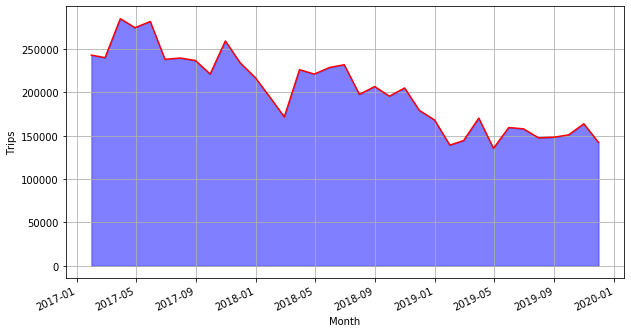

In [40]:
y = df.groupby(pd.Grouper(freq='M')).count()['Unnamed: 0']
# Plot
plt.figure(figsize=(10,5))
plt.fill_between(y.index,y, color='blue', alpha=0.5)
plt.plot(y.index,y.values, color='red')
plt.grid()
plt.xticks(rotation=25, ha='right')
plt.xlabel('Month')
plt.ylabel('Trips')

plt.show()

**Nº of Taxis**

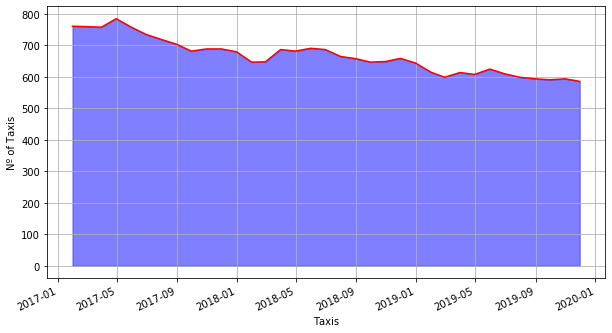

In [41]:
y = df.groupby(pd.Grouper(freq='M'))
y = y.agg({"taxi_id": "nunique"})['taxi_id']

# Plot
plt.figure(figsize=(10,5))
plt.fill_between(y.index,y, color='blue', alpha=0.5)
plt.plot(y.index,y.values, color='red')
plt.grid()
plt.xticks(rotation=25, ha='right')
plt.xlabel('Taxis')
plt.ylabel('Nº of Taxis')

plt.show()

## Trips Features 

In [61]:
tripsVars = ['Trips','Fare Last Month','Tips Last Month','Trips Last Hour','Trips Last Week (Same Hour)','Trips 2 Weeks Ago (Same Hour)']

In [62]:
tripsData = final_df[tripsVars]

**Multicollinearity**

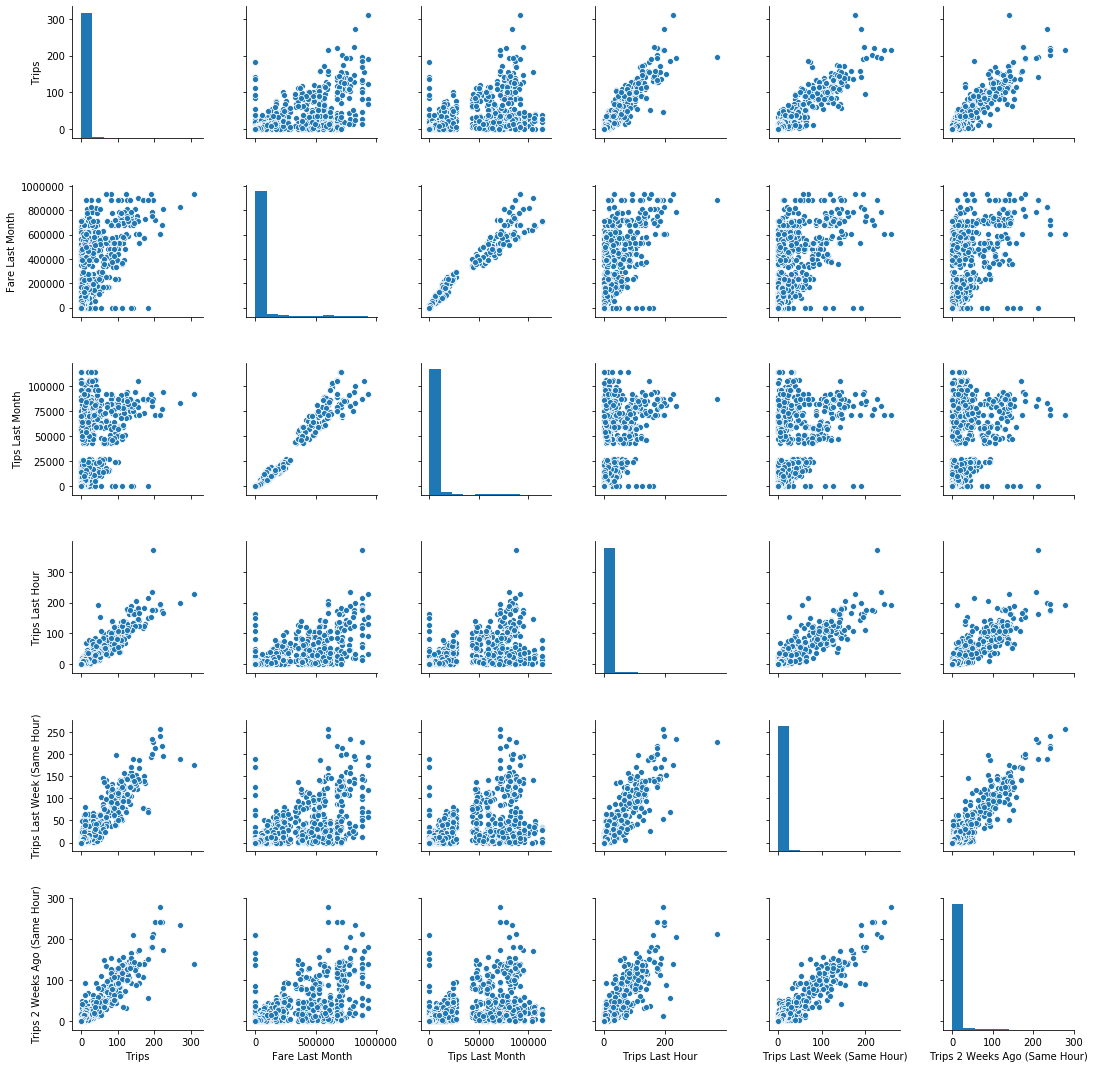

In [70]:
sns.pairplot(tripsData.sample(n = 10000))

Highlights:
- High correlation between Trips and Demand Features
- High correlation between Tips Last Month and Fare Last Month(Reason: Tips are a percentage of Fare)
- There is gap in medium Tips Last Month Value (between \\$26 500-\\$43 000)

**Tips vs Fare Last Month**

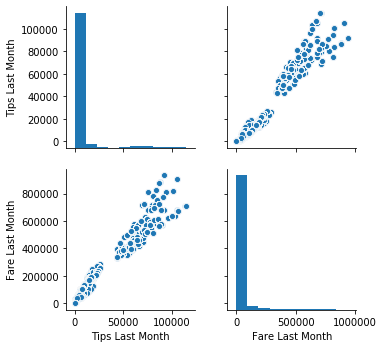

In [71]:
sns.pairplot(final_df[['Tips Last Month','Fare Last Month']])

In [63]:
# Tips Gap
print(final_df['Tips Last Month'][final_df['Tips Last Month']<40000].max())
print(final_df['Tips Last Month'][final_df['Tips Last Month']>40000].min())

26585.830000000005
43100.51999999998


In [64]:
# Avg % of Tips of the Fare
tmp = final_df[final_df['Fare Last Month'] != 0]
print("Avg of Tips of the Fare {:.2f}%".format(100 * (tmp['Tips Last Month']/tmp['Fare Last Month']).mean()))

Avg of Tips of the Fare 3.24%


### Weather Features 

In [65]:
weatherVars = ['Trips','temperature','relative_humidity','wind_direction','wind_speed','precipitation','sky_level']
weatherData = final_df[weatherVars]

In [ ]:
weatherData['sky_level'] = weatherData.sky_level.cat.codes

**Multicollinearity**

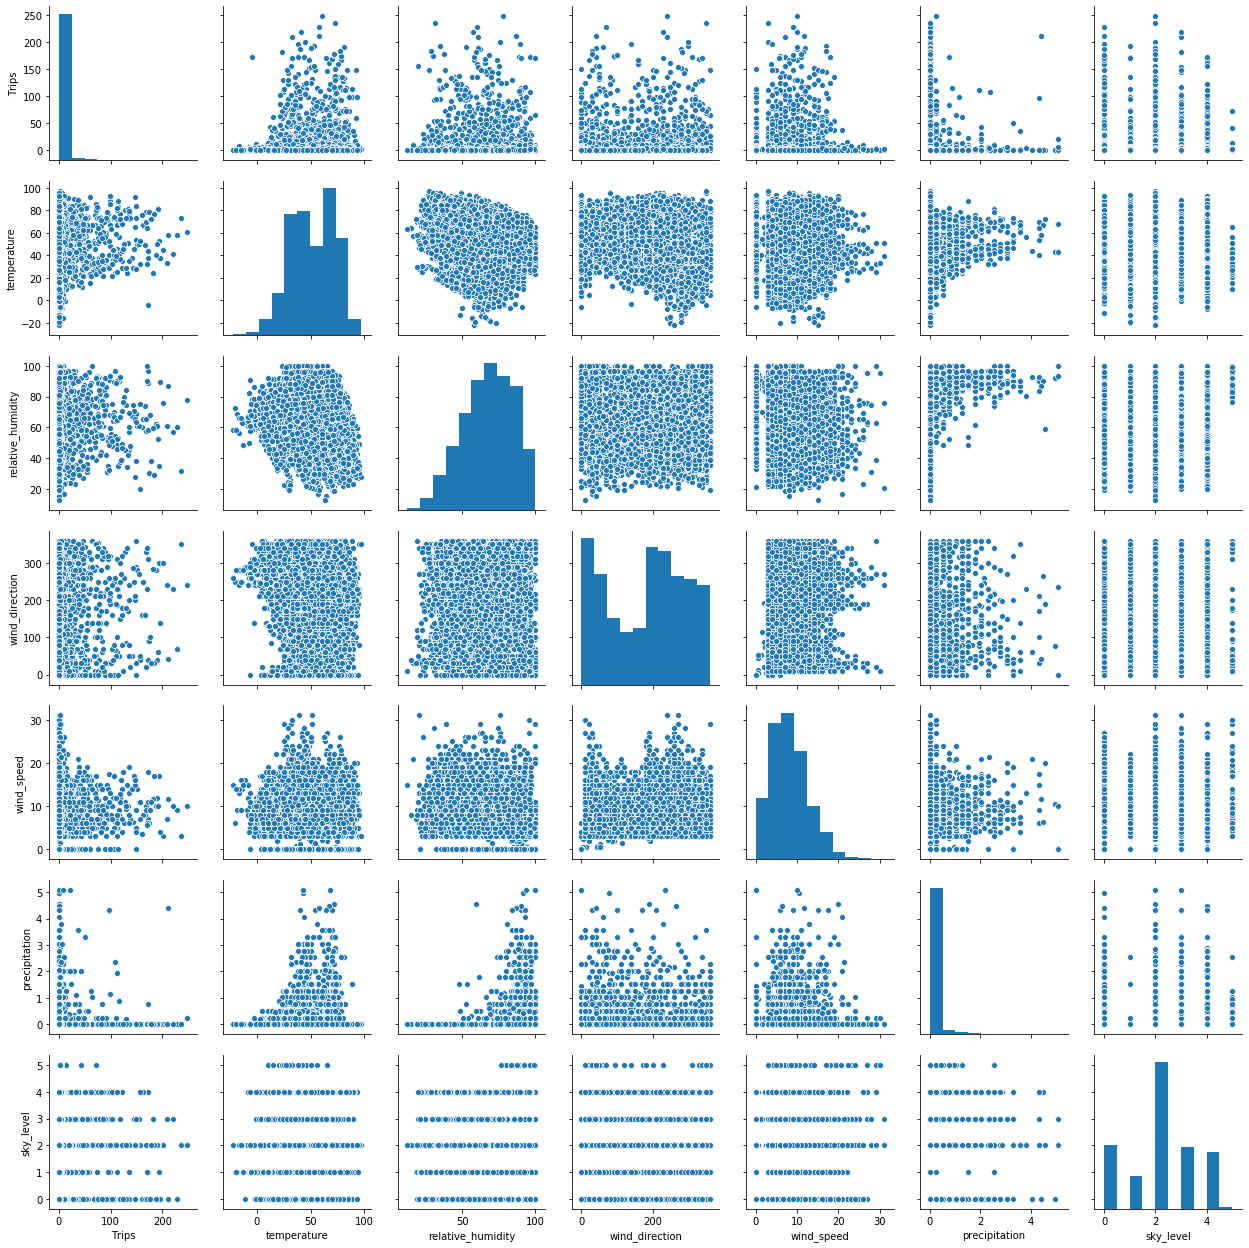

In [76]:
sns.pairplot(weatherData.sample(n = 10000))

Highlights:
- Trips with Precitpitaion: There is a huge difference when precipitation is 0 and when it is not. So we will try to create another variable to check if in a day has rained or not.
- Trips with temperature: There is a difference as well when the temperature is lower than 15ºF
- Wind variables does not seem to have any relation with the number of trips

**Trips vs Precipitation**

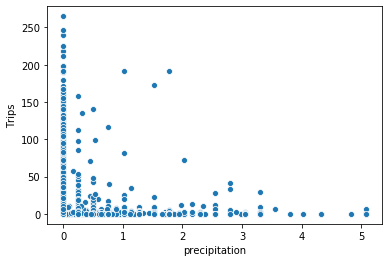

In [77]:
sns.scatterplot(x='precipitation',y='Trips',data=final_df.sample(n=10000))

In [67]:
final_df['precipitation_cat'] =(final_df['precipitation'].round())

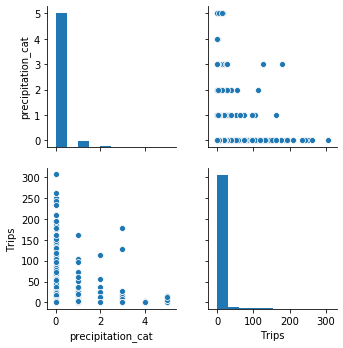

In [68]:
sns.pairplot(final_df[['precipitation_cat','Trips']].sample(n=10000))

We will test our precipitation_cat variable with our target variable

In [69]:
precipitation_cat_size = final_df['precipitation_cat'].shape[0] 
precipitation_cat = final_df['precipitation_cat'].astype('int')
precipitation_cat = precipitation_cat.values.reshape((precipitation_cat_size,1))
f_stat, p_value = f_classif(final_df['Trips'].values.reshape((precipitation_cat_size,1)),precipitation_cat)
print(p_value[0])

8.388161025761691e-11


/Users/dsuarezsouto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [70]:
f_stat, p_value = f_regression(final_df['precipitation'].values.reshape((final_df['precipitation'].shape[0],1)),final_df['Trips'])
print(p_value[0])

0.875275297321968


Great! Our ordinal predictor (precipitation_cat) has a lower p_value than the interval variable (precipitation)

In [84]:
final_df.drop(columns=['precipitation'],inplace=True)

**Trips vs Temperature**

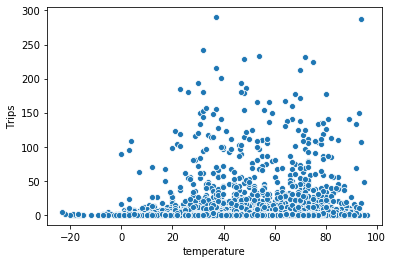

In [71]:
sns.scatterplot(x='temperature',y='Trips',data=final_df.sample(n=10000))

Lets do three bins from the temperature feature

In [72]:
binEdges = [-30,0,20,60,100]
final_df['temperature_cat'] = pd.cut(final_df['temperature'],binEdges, labels = False)

Temperature Bins [ (-30, 0] < (0, 20] < (20, 60] < (60, 100]]

We will test our temperature_cat variable with our target variable

In [74]:
#ANOVA
temperature_cat_size = final_df['temperature_cat'].shape[0] 
temperature_cat = final_df['temperature_cat'].values.reshape((temperature_cat_size,1))
f_stat, p_value = f_classif(final_df['Trips'].values.reshape((temperature_cat_size,1)),temperature_cat)
print(p_value[0])

1.2444824795038473e-80


/Users/dsuarezsouto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [75]:
#F_Regression
f_stat, p_value = f_regression(final_df['temperature'].values.reshape((final_df['temperature'].shape[0],1)),final_df['Trips'])
print(p_value[0])

6.462722367765123e-141


Our ordinal predictor (temperature_cat) has a higher  p_value than the interval variable (temperature)

In [85]:
final_df.drop(columns=['temperature_cat'],inplace=True)

### Date Features

In [9]:
dateVars = ['Trips','daytype', 'Day Name','Month','Hour','Quarter','Year','First Half Month']
dateData = final_df[dateVars]

In [ ]:
dateData['daytype'] = dateData['daytype'].cat.codes
dateData['Day Name'] = dateData['Day Name'].replace('Monday', 0)
dateData['Day Name'] = dateData['Day Name'].replace('Tuesday', 1)
dateData['Day Name'] = dateData['Day Name'].replace('Wednesday', 2)
dateData['Day Name'] = dateData['Day Name'].replace('Thursday', 3)
dateData['Day Name'] = dateData['Day Name'].replace('Friday', 4)
dateData['Day Name'] = dateData['Day Name'].replace('Saturday', 5)
dateData['Day Name'] = dateData['Day Name'].replace('Sunday', 6)

**Trips and Day Name**

In [78]:
dayNames = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

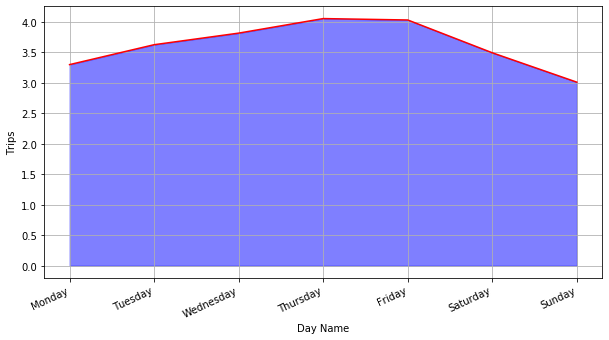

In [79]:
tripsperDayName = final_df.groupby('Day Name').mean()['Trips'][dayNames]

# Plot
plt.figure(figsize=(10,5))
plt.fill_between(tripsperDayName.index,tripsperDayName, color='blue', alpha=0.5)
plt.plot(tripsperDayName.values, color='red')
plt.grid()
plt.xticks(rotation=25, ha='right')
plt.xlabel('Day Name')
plt.ylabel('Trips')

plt.show()

**Trips and Day Type**

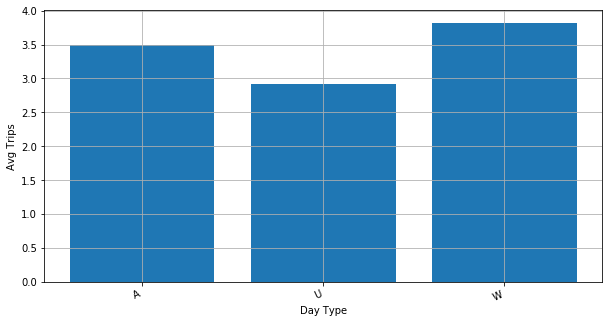

In [80]:
tripsperDayName = final_df.groupby('daytype').mean()['Trips']

# Plot
plt.figure(figsize=(10,5))
plt.bar(tripsperDayName.index,tripsperDayName)
plt.grid()
plt.xticks(rotation=25, ha='right')
plt.xlabel('Day Type')
plt.ylabel('Avg Trips')

plt.show()

**Trips and Month/Quarter**

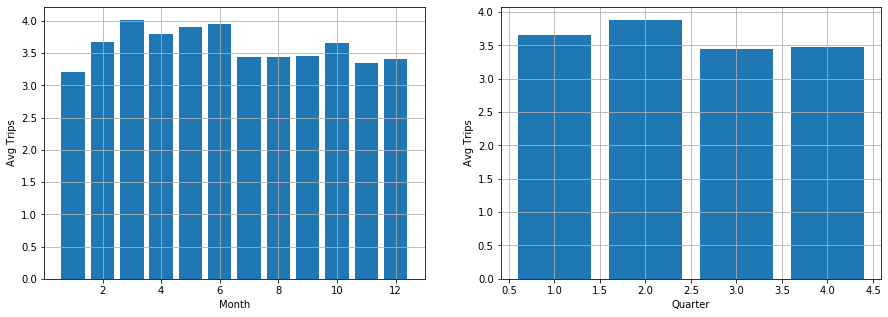

In [81]:
fig, ax = plt.subplots(ncols=2,figsize=(15,5))


tripsperMonth = final_df.groupby('Month').mean()['Trips']
tripsperQuarter = final_df.groupby('Quarter').mean()['Trips']


ax[0].bar(tripsperMonth.index,tripsperMonth)
ax[0].grid()
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Avg Trips')


ax[1].bar(tripsperQuarter.index,tripsperQuarter)
ax[1].grid()
#ax[1].xticks(rotation=25, ha='right')
ax[1].set_xlabel('Quarter')
ax[1].set_ylabel('Avg Trips')

plt.show()

**Trips and Hours**

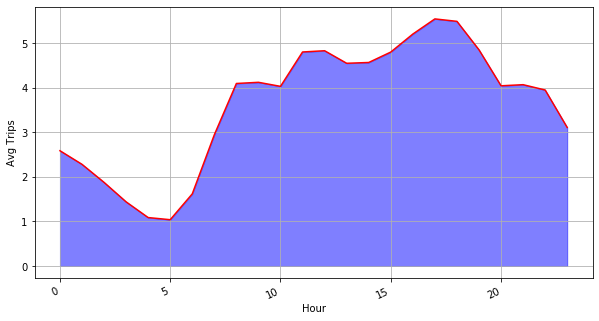

In [82]:
tripsperHour = final_df.groupby('Hour').mean()['Trips']

# Plot
plt.figure(figsize=(10,5))
plt.fill_between(tripsperHour.index,tripsperHour, color='blue', alpha=0.5)
plt.plot(tripsperHour.values, color='red')
plt.grid()
plt.xticks(rotation=25, ha='right')
plt.xlabel('Hour')
plt.ylabel('Avg Trips')

plt.show()

**Trips and First Half Month**

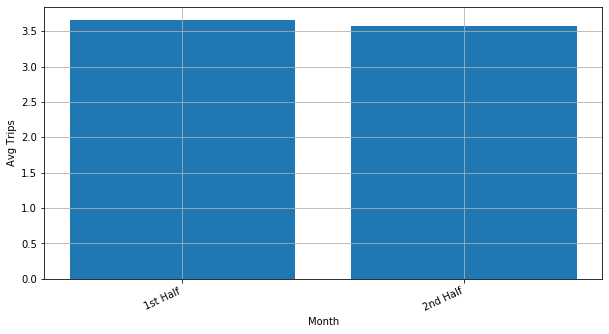

In [17]:
tripsperHalf = final_df.groupby('First Half Month').mean()['Trips'][[1,0]]

# Plot
plt.figure(figsize=(10,5))
plt.bar(['1st Half', '2nd Half'],tripsperHalf)
plt.grid()
plt.xticks(rotation=25, ha='right')
plt.xlabel('Month')
plt.ylabel('Avg Trips')

plt.show()

In [87]:
final_df.to_csv('../../../DataSets/dataset_final.csv')

### Multicollinearity

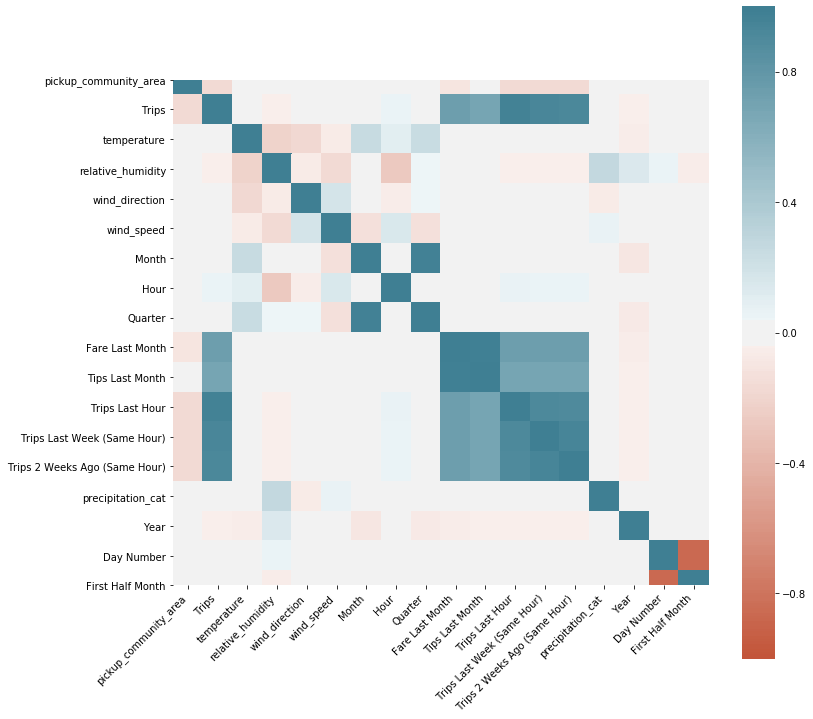

In [18]:
fig, ax = plt.subplots(figsize = (12,12))
corr = final_df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

There is a high correlation between:
- Fare Last Month~Tips Last Month
- Month~Quarter
- Trips Last Hour\~Trips Last Week (Same Hour)\~Trips 2 Weeks Ago (Same Hour) 
- Day Namber~First Half Month